# Visual Clothing Recommender

Since the onset of the COVID-19 pandemic, online shopping has increased quarter over quarter by over 30%. While many retail platforms have completely re-designed themselves to optimize for the trend in online sales, seller to seller markets for the most part remain unchanged. 

For consumers who are trying to avoid fast fashion, or who want to shop based on item appearance rather than brand, sites like eBay, Etsy, Grailed, thredup and many others offer significant challenges. Because these sites rely on seller input to catalogue and organize their data, most items contain the same keywords designed to direct traffic. The massive number of listings can result in endless scrolling and hundreds of identical entries, leading to fatigue on the client's part. 

On the seller's side, it may be extremely difficult to market unique vintage products that would easily sell at an in-person market but don't fit conventional search criteria. 

Finally, for the host sites themselves, a more easily navigated interface could boost confidence in their brand and direct more traffic, sales and ad revenue. 

For this project, my proposed solution to the problems above is to create a platform capable of analyzing image data and recommending clothing based on color and appearance as well as conventional criteria like size or price. Here are a few ways that this platform could benefit the buyer, seller and host:

* Buyers can use one listing to search for identical items at lower prices or in different sizes
* Images from social media or music videos could be input into search engines to return similar results
* Users could take photos of their existing wardrobe and search for items in different categories that match specific colors
* International sellers could easily market items without being hindered by language barriers
* Host sites can create sleek, visual interfaces to make the experience on their site more closely mimic in-person shopping

## This Notebook

This notebook contains a condensed summary of the steps used to process data, create recommender models and evaluate them. For a more in depth look at the process used to gather the data and pre-process the images used in this notebook, please see the image_process and data_import notebooks. For data cleaning, see the EDA notebook. For a more in-depth look at the modeling process, see the model notebook. All four can be found in this [github repo](http://github.com/bagnine/Clothing_Recommender/).

## Importing Libraries and Data

In [1]:
# Basic data and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

# Natural language processing
import re
import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Image processing/manipulation
from PIL import Image
import cv2 as cv
from colorthief import ColorThief

# Modeling tools and evaluation metrics
from sklearn.metrics.pairwise import cosine_similarity
import scipy.spatial.distance as dist
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.stats import ttest_ind

# System tools
import os
import sys
sys.path.append('./src/modules')

from collections import Counter

# Modules created for this project
import EDA
import image_process
import model

In [2]:
df = pd.read_csv('./src/data/grailed.csv')
modeldf = pd.read_csv('./src/data/model_data.csv')
colordf = pd.read_csv('./src/data/colors.csv')

In [3]:
colordf.set_index('Unnamed: 0', inplace = True)
modeldf.set_index('Unnamed: 0', inplace = True)

colordf['0'] = colordf['0'].apply(lambda x: eval(x))
colordf['1'] = colordf['1'].apply(lambda x: eval(x))
colordf['2'] = colordf['2'].apply(lambda x: eval(x))

## Visualizing feature distributions

In [4]:
# Set the plot style for all visualizations
sns.set_style('whitegrid')

Text(0, 0.5, 'Frequency')

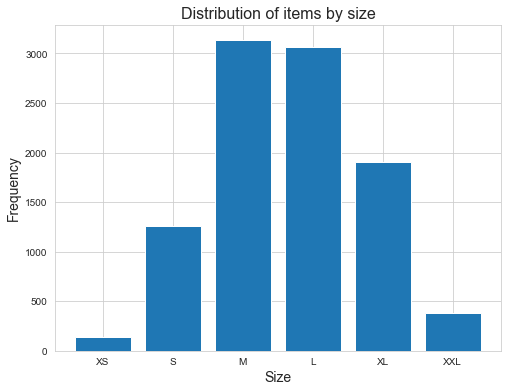

In [5]:
# Plot distribution of sizes 
size_dist = {'XS': modeldf.XS.sum(),
             'S': modeldf.S.sum(),
             'M': modeldf.M.sum(),
             'L': modeldf.L.sum(),
             'XL': modeldf.XL.sum(),
             'XXL': modeldf.XXL.sum()}
fig, ax = plt.subplots(figsize = (8,6))
plt.bar(height= size_dist.values(), x = size_dist.keys())
plt.title('Distribution of items by size', size = 16)
plt.xlabel('Size', size = 14)
plt.ylabel('Frequency', size = 14)

The size distribution is relatively normal- note that due to the imbalance we expect predictions on XS items to be less accurate than others. 

<BarContainer object of 32 artists>

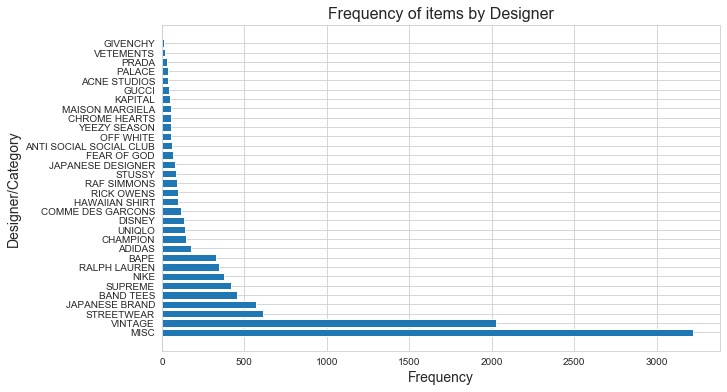

In [6]:
# Plot distribution of designers
df.Designer = EDA.bin_designers(df.Designer);

fig, ax = plt.subplots(figsize = (10,6))
ax.set_title('Frequency of items by Designer', size = 16)
ax.set_ylabel('Designer/Category', size = 14)
ax.set_xlabel('Frequency', size = 14)
ax.barh(y= df.Designer.value_counts().keys(), width = df.Designer.value_counts())

In spite of attempts to bin the designers, there are still far more 'Misc' items than anything else. This is a good sign for the purpose of my model- to create recommendations of items that are difficult to search through conventional methods.

Text(0, 0.5, 'Frequency')

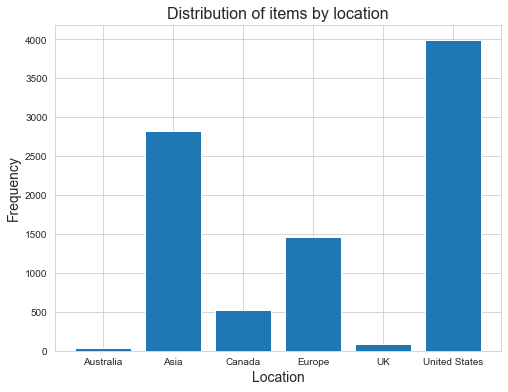

In [7]:
# Plot Distribution of item locations
loc_dist = {'Australia': modeldf.AU.sum(),
             'Asia': modeldf.Asia.sum(),
             'Canada': modeldf.Canada.sum(),
             'Europe': modeldf.Europe.sum(),
             'UK': modeldf.UK.sum(),
             'United States': modeldf.US.sum()}
fig, ax = plt.subplots(figsize = (8,6))
plt.bar(height= loc_dist.values(), x = loc_dist.keys())
plt.title('Distribution of items by location', size = 16)
plt.xlabel('Location', size = 14)
plt.ylabel('Frequency', size = 14)

More than half of the listings in this data set are based in the US or Asia. The reason location data is important here is that it has an effect on price and likes, as shown below.

<BarContainer object of 6 artists>

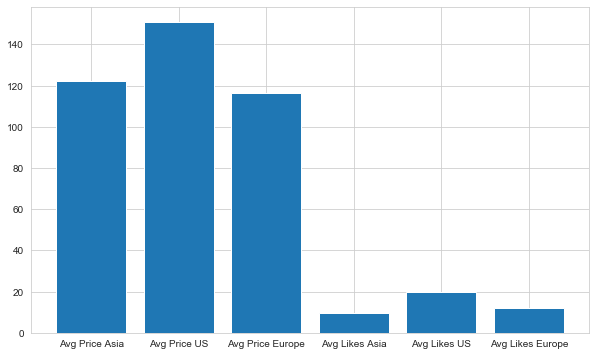

In [8]:
# Find average price by location, average followers

loc_stats = {'Avg Price Asia': modeldf[modeldf['Asia']==1].Price.mean(),
             'Avg Price US': modeldf[modeldf['US']==1].Price.mean(),
             'Avg Price Europe': modeldf[modeldf['Europe']==1].Price.mean(),
             'Avg Likes Asia': modeldf[modeldf['Asia']==1].FollowerCount.mean(),
             'Avg Likes US': modeldf[modeldf['US']==1].FollowerCount.mean(),
             'Avg Likes Europe': modeldf[modeldf['Europe']==1].FollowerCount.mean()
}
fig, ax = plt.subplots(figsize = (10,6))
plt.bar(x = loc_stats.keys(), height = loc_stats.values())

There's a large difference between the Price and likes of items from sellers in the United States and those outside. This may be something to try to incorporate into my recommender models.

In [9]:
# Performing a T-Test to check the significance of the relationship between likes and price

ttest_ind(modeldf.FollowerCount, modeldf.Price)

Ttest_indResult(statistic=-51.453636428424545, pvalue=0.0)

In [10]:
# Checking the correlation between the two values

modeldf.FollowerCount.corr(modeldf.Price)

0.22734320560865098

## Using Euclidean Distance to find Color Similarity

I developed a function that utilizes sklearn's spatial distance module to find the closest colors by interpretting RGB values as a point in 3D space. Note that the Euclidean distance numbers reflect the shortest distance between the target tuple and those of all colors in the dataframe in a 255x255x255 axis. 

In [74]:
rgbdf = modeldf.merge(colordf, left_index=True, right_index = True)

In [75]:
list_of_columns = [rgbdf['0'], rgbdf['1'], rgbdf['2']]

For the most part, the function does very well at finding matching colors in items that have 2-3 dominant colors

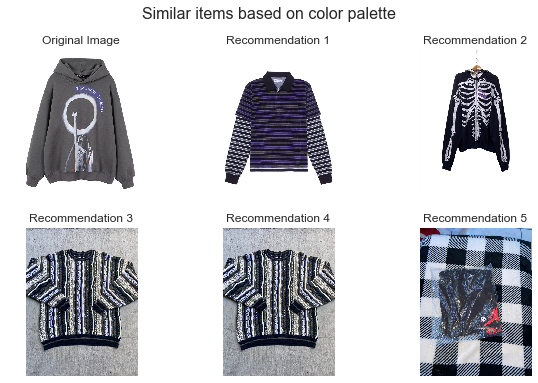

In [13]:
EDA.display_closest_colors(13, list_of_columns, rgbdf)

For extremely colorful items it doesn't do quite as well, but some similarities are still evident.

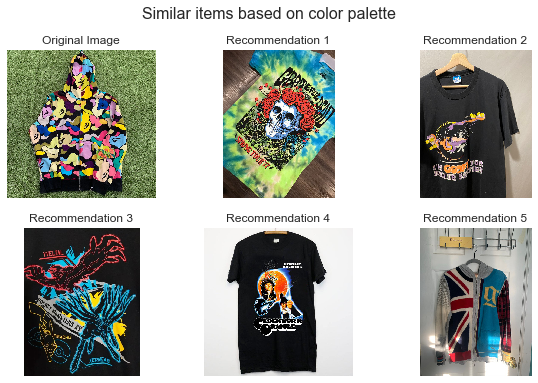

In [14]:
EDA.display_closest_colors(32, list_of_columns, rgbdf)

It's also relatively successful at finding different listings of the target item, which could be useful for finding a desired item in a different size or at a lower price.

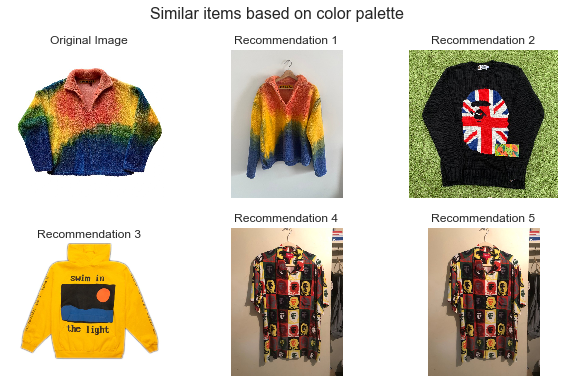

In [15]:
EDA.display_closest_colors(391, list_of_columns, rgbdf)

## Evaluation

The reading I've done about evaluation metrics for recommender systems has overwhelmingly stated that the only metric that matters is user sentiment. With that said, it's risky for a company to use a new recommender, even for A/B testing without doing everything possible to vet it. 

With that in mind, I've chosen 5 main metrics by which to judge my predictions:

### Cosine Similarity

By plotting features as vectors and comparing their angle of divergence, this metric is capable of judging the overall similarity of items' features in aggregate. For that reason, it's overall the best indication that an item is similar. Because Cosine Similarity in a value between 0 and 1, the closest value to 1 is the best prediction.

### Standard Deviation of Likes

One of the goals of this recommender is to solve the long tail problem by recommending less popular items to the buyer. However, a model that overpredicts unpopular items is likely to be disdained and distrusted by the user. For that reason, my metric of success here is a Standard Deviation of Likes that mimics the dataset as a whole. 

### Difference of Mean Price

In order to ensure that the recommendations provided are within the range a user wants to spend, I'm finding the average price of all recommendations and comparing it to the target price. The lowest possible number is ideal here.

### Mean Euclidean Distance of Color

As shown in the section above, Euclidean distance is a simple and relatively good metric for evaluating color similarity. The smaller the value, the smaller the total difference in colors is to the target.

### Visual Inspection

This is a subjective measure, and given time to do so I'll vet it using user-input parameters and have them rate each return.

In [16]:
modeldf.FollowerCount.std()

29.889027881318835

In [17]:
#Generate recommendations from each of the targets above

rec13 = EDA.find_closest_colors(13, list_of_columns, modeldf)
rec32 = EDA.find_closest_colors(32, list_of_columns, modeldf)
rec391 = EDA.find_closest_colors(391, list_of_columns, modeldf)

In [18]:
#Evaluate 1st rec
model.evaluate_recs(13, rec13, modeldf, rgbdf)

Average Cosine Similarity with target item: 0.4947863295108208
Average Euclidean Color Distance from target item: 8.670093057994155
Standard Deviation of likes in Recommendation Group: 6.735478206235
Difference in mean price and target item: 55.0


Lots of variation in the cosine similarity, Euclidean distance is very low (as expected since that's what this model is using to predict), STD of likes is very low, and the price is very close. Not bad!

In [19]:
model.evaluate_recs(32, rec32, modeldf, rgbdf)

Average Cosine Similarity with target item: 0.6926468612283434
Average Euclidean Color Distance from target item: 29.82833594212466
Standard Deviation of likes in Recommendation Group: 28.682166352398607
Difference in mean price and target item: -265.1666666666667


More even on the cosine similarity, near perfect standard deviation of likes but an extremely large divide on mean price.

In [20]:
model.evaluate_recs(391, rec391, modeldf, rgbdf)

Average Cosine Similarity with target item: 0.5783901803637731
Average Euclidean Color Distance from target item: 25.781214516471117
Standard Deviation of likes in Recommendation Group: 28.50964748992874
Difference in mean price and target item: -701.5


Again, lots of variance in cosine similarity, good STD likes and a giant difference in mean price. 

It looks like this model is doing an okay job but it will need to get a lot more complex to hit all the metrics.

## Splitting and scaling

For the next section, I created a subset of my data for evaluation. The purpose of evaluating a smaller subset of data is to see how my modeling process performs on only data a user would be likely to input in a search filter. I will be scaling and evaluating both data sets side by side. Note that the evaluation metrics will be changed by the scaling process, but can still be made interpretable. 

In [4]:
# Create a variant DataFrame with just price, sizing info, number of likes and a binary vintage classifier
simple_df = modeldf[['Price', 'L', 'M', 'S', 'XL', 'XS', 'XXL', 'FollowerCount', 'VINTAGE']]

# Scale both DataFrames using StandardScaler and turn back into DataFrames with the same column names
kcolumns = modeldf.columns
scolumns = simple_df.columns

scaler = MinMaxScaler()

kdf = pd.DataFrame(scaler.fit_transform(modeldf), columns=kcolumns)
kdf.set_index(modeldf.index, inplace=True)

simple_df = pd.DataFrame(scaler.fit_transform(simple_df), columns=scolumns)
simple_df.set_index(modeldf.index, inplace=True)

## K-Means Clustering

For this recommender, I found the optimum number of clusters for each data set using the Calinski-Harabasz score. Next, I created a function to create clusters from the data and return all rows in the same cluster as my target. 

In [22]:
# Instatiate and fit the model and make cluster assignments to my abbreviated data set

k_means = KMeans(n_clusters=10) 

k_means.fit(simple_df) 

cluster_assignments = k_means.predict(simple_df) 

# Check the CH score to see the quality in the separation of the clusters

print(calinski_harabasz_score(kdf, cluster_assignments))

415.71647349610134


Based on the graph below I selected 10 as the optimal number of clusters for my simple data set.

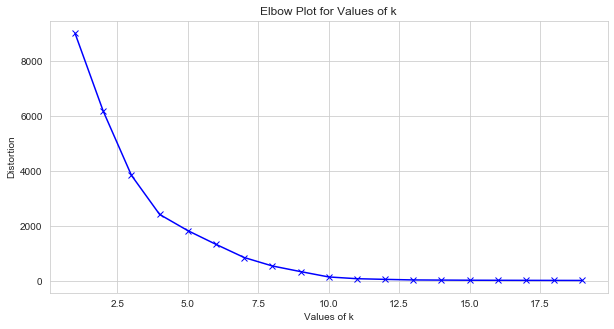

In [23]:
# Create an elbow plot to find the optimum value for K

clusters = []
K = range(1,20)
for k in K:
    kmm = KMeans(n_clusters=k)
    kmm.fit(simple_df)
    clusters.append(kmm.inertia_)

plt.figure(figsize=(10,5))
plt.plot(K, clusters, 'bx-')
plt.xlabel('Values of k')
plt.ylabel('Distortion')
plt.title('Elbow Plot for Values of k')
plt.show()

In [24]:
# Instantiate, fit and predict on the full data set and check the CH score for optimum clustering

k_means1 = KMeans(n_clusters = 18)

k_means1.fit(kdf)

cluster_assignments1 = k_means1.predict(kdf)

print(calinski_harabasz_score(kdf, cluster_assignments1))

367.0013372638196


Based on this second graph I selected 18 as the optimum number of clusters for the full data set. 

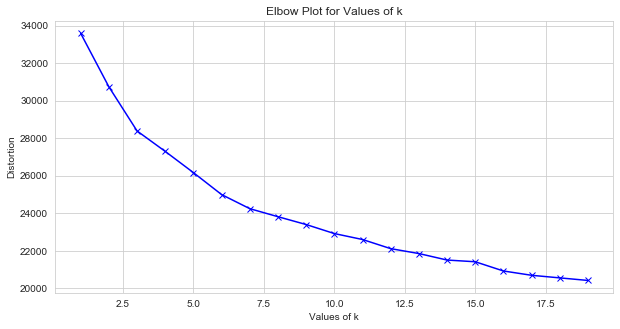

In [25]:
# Elbow plot to determine the optimal value for K

clusters = []
K = range(1,20)
for k in K:
    kmm = KMeans(n_clusters=k)
    kmm.fit(kdf)
    clusters.append(kmm.inertia_)

plt.figure(figsize=(10,5))
plt.plot(K, clusters, 'bx-')
plt.xlabel('Values of k')
plt.ylabel('Distortion')
plt.title('Elbow Plot for Values of k')
plt.show()

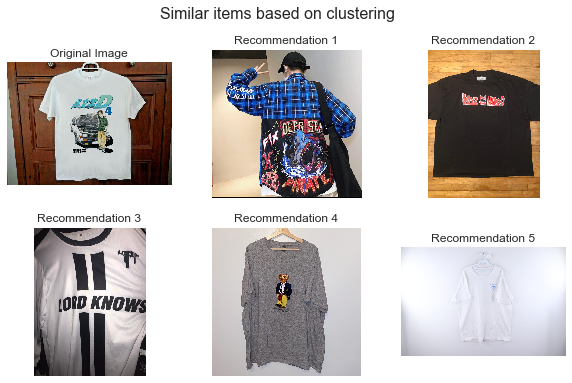

In [26]:
model.display_kmeans_recs(simple_df.loc[[127]], simple_df, n_clusters = 12)

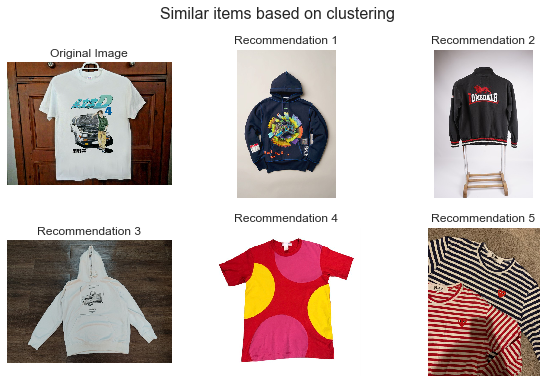

In [27]:
model.display_kmeans_recs(kdf.loc[[127]], kdf, n_clusters = 18)

In [28]:
rec127s = model.cluster_recommendations(simple_df.loc[[127]], simple_df, 11)
rec127k = model.cluster_recommendations(kdf.loc[[127]], kdf, 18)

In [29]:
model.evaluate_recs(127, rec127k, kdf, rgbdf)

Average Cosine Similarity with target item: 0.08215519483182109
Average Euclidean Color Distance from target item: 88.84543825920267
Standard Deviation of likes in Recommendation Group: 0.043708856674628004
Difference in mean price and target item: 0.011544819977211303


In [30]:
print('Standard Deviation of likes unscaled:', round(modeldf.FollowerCount.max() * 0.0350))
print('Difference in mean price and target item unscaled:', round(modeldf.Price.max() * .0096))

Standard Deviation of likes unscaled: 19.0
Difference in mean price and target item unscaled: 96.0


In [31]:
model.evaluate_recs(127, rec127s, simple_df, rgbdf)

Average Cosine Similarity with target item: 0.9975487104190071
Average Euclidean Color Distance from target item: 87.26956485036476
Standard Deviation of likes in Recommendation Group: 0.059345230820878295
Difference in mean price and target item: 0.01163801622599969


In [32]:
print('Standard Deviation of likes unscaled:', round(modeldf.FollowerCount.max() * 0.0482))
print('Difference in mean price and target item unscaled:', round(modeldf.Price.max() * .0120))

Standard Deviation of likes unscaled: 27.0
Difference in mean price and target item unscaled: 120.0


This model performed very poorly in cosine similarity but did okay in Likes and Price. I'm not sure the whether this will make it into the final model, but the crossover of some of its selections with my other models are worth considering. 

## Cosine Similarity

Cosine similarity is likely the best quantitative measure of the similarity of one row to another. In order to find the most similar items based on my features, I created a function that finds of cosine similarity of a target row and every other item in the DataFrame and returns the top 5 scores and indices. Next, I created a second function to display them. 

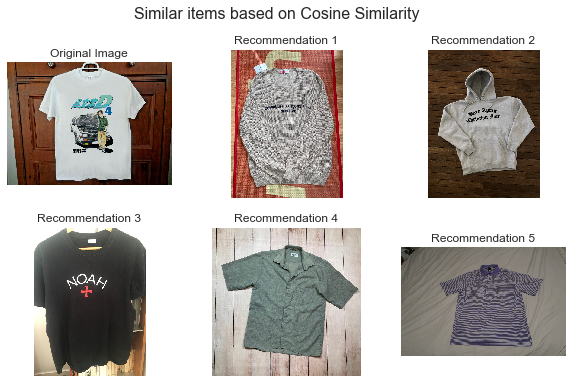

In [33]:
# Find cosine-similar items using the full dataset

model.display_cosim_recs(kdf.loc[[127]], kdf)

In [34]:
model.evaluate_recs(127, [i[1] for i in model.cosine_similarity_recs(kdf.loc[[127]], kdf)], kdf, rgbdf)

Average Cosine Similarity with target item: 0.24914912228778108
Average Euclidean Color Distance from target item: 100.49170956651275
Standard Deviation of likes in Recommendation Group: 0.16125100670060222
Difference in mean price and target item: 0.010657687092974152


In [35]:
print('Standard Deviation of likes unscaled:', round(modeldf.FollowerCount.max() * 0.1613))
print('Difference in mean price and target item unscaled:', round(modeldf.Price.max() * .0106))

Standard Deviation of likes unscaled: 89.0
Difference in mean price and target item unscaled: 106.0


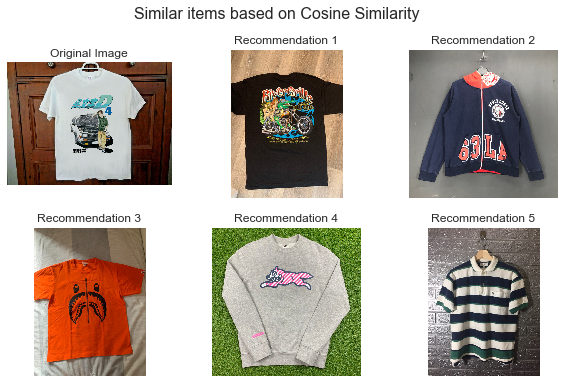

In [36]:
# Find cosine-similar items using the abbreviated dataset

model.display_cosim_recs(simple_df.loc[127:127], simple_df)

In [37]:
model.evaluate_recs(127, [i[1] for i in model.cosine_similarity_recs(simple_df.loc[[127]], simple_df)], simple_df, rgbdf)

Average Cosine Similarity with target item: 0.3395963645224922
Average Euclidean Color Distance from target item: 94.52015780411509
Standard Deviation of likes in Recommendation Group: 0.029367778967290627
Difference in mean price and target item: 0.00804605365517548


In [38]:
print('Standard Deviation of likes unscaled:', round(modeldf.FollowerCount.max() * 0.0293))
print('Difference in mean price and target item unscaled:', round(modeldf.Price.max() * .0080))

Standard Deviation of likes unscaled: 16.0
Difference in mean price and target item unscaled: 80.0


This model performed substantially better on price, and obviously the consine similarity was good.

For a second test, I chose a very expensive listing ($2500) to see how the model would handle an outlier value.

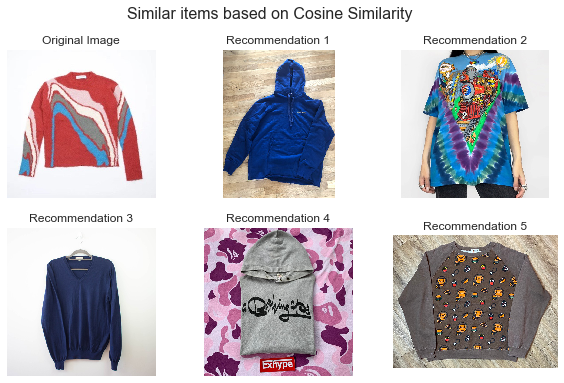

In [39]:
model.display_cosim_recs(kdf.loc[[4363]], kdf)

In [40]:
model.evaluate_recs(4363, [i[1] for i in model.cosine_similarity_recs(kdf.loc[[127]], kdf)], kdf, rgbdf)

Average Cosine Similarity with target item: 0.31158864918216855
Average Euclidean Color Distance from target item: 123.73155258445018
Standard Deviation of likes in Recommendation Group: 0.16125100670060222
Difference in mean price and target item: -0.23679180280500542


In [41]:
print('Standard Deviation of likes unscaled:', round(modeldf.FollowerCount.max() * 0.1613))
print('Difference in mean price and target item unscaled:', round(modeldf.Price.max() * .2367))

Standard Deviation of likes unscaled: 89.0
Difference in mean price and target item unscaled: 2367.0


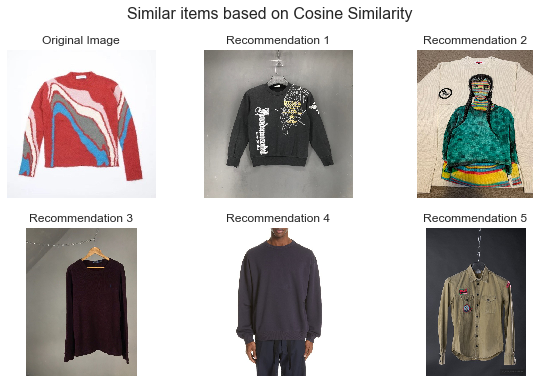

In [42]:
model.display_cosim_recs(simple_df.loc[[4363]], simple_df)

In [43]:
model.evaluate_recs(4363, [i[1] for i in model.cosine_similarity_recs(simple_df.loc[[127]], simple_df)], simple_df, rgbdf)

Average Cosine Similarity with target item: 0.3321988615443874
Average Euclidean Color Distance from target item: 133.15107594276446
Standard Deviation of likes in Recommendation Group: 0.029367778967290627
Difference in mean price and target item: -0.2394034362428041


In [44]:
print('Standard Deviation of likes unscaled:', round(modeldf.FollowerCount.max() * 0.0294))
print('Difference in mean price and target item unscaled:', round(modeldf.Price.max() * .2394))

Standard Deviation of likes unscaled: 16.0
Difference in mean price and target item unscaled: 2394.0


Though it did okay on the other metrics, the model handled the outlier price poorly as the average difference per item was almost the full price of the target. 

## Nearest Neighbors

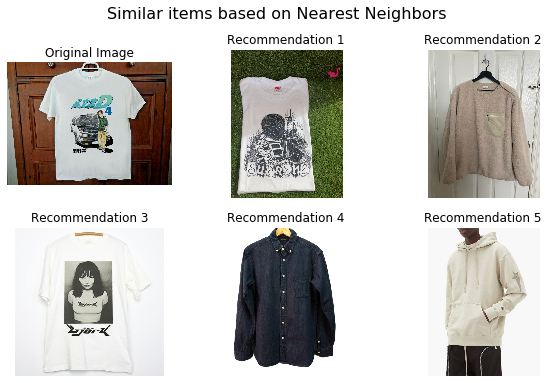

In [6]:
model.display_KNN_recs(kdf.loc[[127]], kdf, 8)

In [10]:
model.evaluate_recs(127, (model.KNN_recs(kdf.loc[[127]], kdf, 8)), kdf, colordf)

Average Cosine Similarity with target item: 0.6893679010636159
Average Euclidean Color Distance from target item: 84.52851614869103
Standard Deviation of likes in Recommendation Group: 0.11522407593036131
Difference in mean price and target item: 0.010462092418483698


In [12]:
print('Standard Deviation of likes unscaled:', round(modeldf.FollowerCount.max() * 0.1152))
print('Difference in mean price and target item unscaled:', round(modeldf.Price.max() * .0104))

Standard Deviation of likes unscaled: 64.0
Difference in mean price and target item unscaled: 104.0


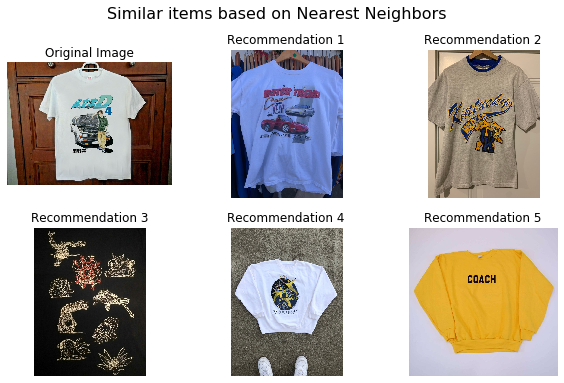

In [7]:
model.display_KNN_recs(simple_df.loc[[127]], simple_df, 8)

In [11]:
model.evaluate_recs(127, (model.KNN_recs(simple_df.loc[[127]], simple_df, 8)), simple_df, colordf)

Average Cosine Similarity with target item: 0.9999944747843084
Average Euclidean Color Distance from target item: 88.80300081018736
Standard Deviation of likes in Recommendation Group: 0.0020529700260309104
Difference in mean price and target item: 0.001400280056011203


In [13]:
print('Standard Deviation of likes unscaled:', round(modeldf.FollowerCount.max() * 0.0020))
print('Difference in mean price and target item unscaled:', round(modeldf.Price.max() * .0014))

Standard Deviation of likes unscaled: 1.0
Difference in mean price and target item unscaled: 14.0


Solid performance across the board from this model. It performed exceptionally well on the simple data set- my only complaint would be that the Standard Deviation of Likes it too small. 

## Ensemble Model

In [89]:
def ensemble_recs(input_row, dataframe, color_dataframe, n_clusters= 18, model_weights = None):
    cos_sim = []
    color_output = []
    knn = model.KNN_recs(input_row, dataframe, 8, n_recs = 500)
    kmean = model.cluster_recommendations(input_row, dataframe, n_clusters=n_clusters)

    for i in dataframe.index:
        try:
            color_output.append((sum(
                [dist.euclidean(color_dataframe['0'][input_row.index[0]], color_dataframe['0'][i]),
                dist.euclidean(color_dataframe['1'][input_row.index[0]], color_dataframe['1'][i]),
                dist.euclidean(color_dataframe['2'][input_row.index[0]], color_dataframe['2'][i])]), i))
        except KeyError:
            continue
    
        try:
            cos_sim.append((cosine_similarity(input_row, dataframe.iloc[i].values.reshape(1,-1)), i))
        
        except IndexError:
            continue
    cos_sim = [i[1] for i in sorted(cos_sim[:-2:])][0:500]
    color_output = [i[1] for i in sorted(color_output)][0:500]
    
    if model_weights == 'visual':
        e = cos_sim + color_output + color_output + knn + kmean
    elif model_weights == 'cos_sim':
        e = cos_sim + cos_sim + color_output + knn + kmean
    else:
        e = cos_sim + color_output + knn + kmean
    
    rec_dict = Counter(e)
    f = list(rec_dict.keys())
    g = list(rec_dict.values())
    
    max_ = [i for i, x in enumerate(g) if x == max(g)]
    recs = [f[i] for i in max_]
    if len(recs) >= 10:
        return recs[:10]
    max_minus = [i for i, x in enumerate(g) if x == max(g)-1]
    recs = recs + [f[i] for i in max_minus]
    if len(recs) >= 10:
        return recs[:10]
    max_minus_2 = [i for i, x in enumerate(g) if x == max(g)-2]
    recs = recs + [f[i] for i in max_minus_2]

    return recs[:10]
    

In [91]:
rec3545 = ensemble_recs(kdf.loc[[3545]], kdf, colordf)

In [92]:
model.evaluate_recs(3545, rec3545, kdf, colordf)

Average Cosine Similarity with target item: 0.3461849045372916
Average Euclidean Color Distance from target item: 58.241418592666506
Standard Deviation of likes in Recommendation Group: 0.04192673411296452
Difference in mean price and target item: 0.003600720144028808


In [93]:
print('Standard Deviation of likes unscaled:', round(modeldf.FollowerCount.max() * 0.0419))
print('Difference in mean price and target item unscaled:', round(modeldf.Price.max() * .0036))

Standard Deviation of likes unscaled: 23.0
Difference in mean price and target item unscaled: 36.0


In [96]:
rec3545s = ensemble_recs(simple_df.loc[[3545]], simple_df, colordf, model_weights='visual')

In [97]:
model.evaluate_recs(3545, rec3545s, simple_df, colordf)

Average Cosine Similarity with target item: 0.9997871986489043
Average Euclidean Color Distance from target item: 34.84310299421932
Standard Deviation of likes in Recommendation Group: 0.01604326991575228
Difference in mean price and target item: 0.0008901780356071216


In [114]:
def show_recs(target, recs):
    images = []
    images.append(Image.open(f'./src/images/{target}.jpg'))
    for i in recs:
        images.append(Image.open(f'./src/images/{i}.jpg'))
    
    # Display the original image and top five closest
    fig, ax = plt.subplots(2, 5, figsize = (12,6))
    fig.suptitle('Ensemble Recommendations', size = 16)
    ax[0,0].imshow(images[0])
    ax[0,0].axis('off')
    ax[0,0].set_title('Original Image')
    ax[0,1].imshow(images[1])
    ax[0,1].axis('off')
    ax[0,1].set_title('Recommendation 1')
    ax[0,2].imshow(images[2])
    ax[0,2].axis('off')
    ax[0,2].set_title('Recommendation 2')
    ax[0,3].imshow(images[3])
    ax[0,3].axis('off')
    ax[0,3].set_title('Recommendation 3')
    ax[0,4].imshow(images[3])
    ax[0,4].axis('off')
    ax[0,4].set_title('Recommendation 4')
    ax[1,0].imshow(images[4])
    ax[1,0].axis('off')
    ax[1,0].set_title('Recommendation 5')
    ax[1,1].imshow(images[5])
    ax[1,1].axis('off')
    ax[1,1].set_title('Recommendation 6')
    ax[1,2].imshow(images[6])
    ax[1,2].axis('off')
    ax[1,2].set_title('Recommendation 7')
    ax[1,3].imshow(images[7])
    ax[1,3].axis('off')
    ax[1,3].set_title('Recommendation 8')
    ax[1,4].imshow(images[8])
    ax[1,4].axis('off')
    ax[1,4].set_title('Recommendation 9')

    return plt.show()

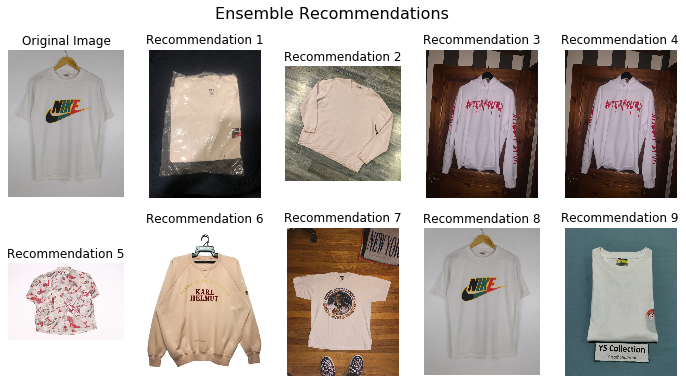

In [115]:
show_recs(3545, rec3545s)

In [121]:
recs125s = ensemble_recs(simple_df.loc[[125]], simple_df, colordf, model_weights='visual')

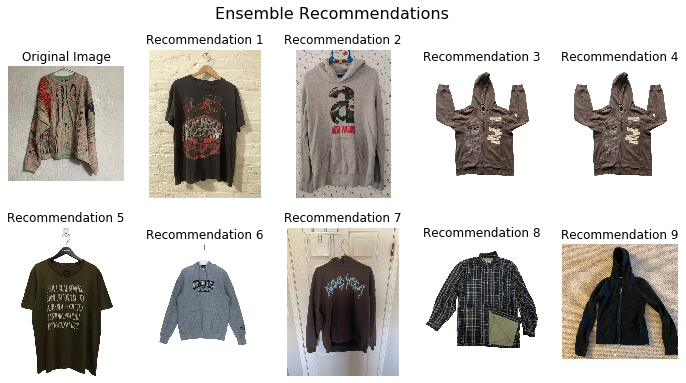

In [122]:
show_recs(125, recs125s)